In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from google.colab import drive
import math
import heapq
drive.mount('/content/drive')

Mounted at /content/drive


First, we need to read the cleaned user data.

In [ ]:
users_df = pd.read_csv('/content/drive/MyDrive/CSC413 [Group]/Setup/Data/ml-1m/ratings.dat', sep='::', encoding='latin-1', header=None)
movies = pd.read_csv('/content/drive/MyDrive/CSC413 [Group]/Setup/Data/ml-1m/movies.dat', sep='::', encoding='latin-1', header=None)

<ipython-input-5-e9318aa75a76>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users_df = pd.read_csv('/content/drive/MyDrive/CSC413 [Group]/Setup/Data/ml-1m/ratings.dat', sep='::', encoding='latin-1', header=None)
<ipython-input-5-e9318aa75a76>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv('/content/drive/MyDrive/CSC413 [Group]/Setup/Data/ml-1m/movies.dat', sep='::', encoding='latin-1', header=None)


In [ ]:
users_np = users_df.to_numpy()
users_df

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [ ]:
movies_np = movies.to_numpy()
movies

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


Next, we will create a vector for each user where each entry corresponds to a unique movie. This entry will contain the user's rating for the movie if they rated it, and 0 otherwise.

To make this easier, we will first create a dictionary mapping movie IDs to their index in the movies.csv file.

In [ ]:
NUM_USERS = 6040
NUM_MOVIES = 3883

def ids_to_indices(movies):
  """
  Given movies.csv in array form, return a dictionary mapping movie IDs to their
  index in the file.
  """
  id_to_idx = dict()

  for i in range(len(movies)):
    id_to_idx[movies[i][0]] = i

  return id_to_idx

In [ ]:
def initialize(users_np, id_to_idx):
  '''
  Given a matrix of reviews and a map between movie IDs and their indices in an
  ordered list, return the following in a tuple:
  - a matrix of ratings, where the (i,j) entry contains user i's rating for movie
  j if they rated it and 0 otherwise
  - a dictionary mapping each user ID to a list of movies they've reviewed
  - an array containing the "norm" for each user used in the normalized Cosine
  Jaccard measure
  - an array containing the average ratings given by each user to the movies
  they've reviewed
  '''
  rating_matrix = np.zeros(((NUM_USERS, NUM_MOVIES)))
  movies_reviewed = dict() # maps a user ID to the list of movies they've reviewed
  users_norm = np.zeros(NUM_USERS) # contains the "norm" for each user used in the normalized Cosine Jaccard measure
  avg_ratings = np.zeros(NUM_USERS)
  num_ratings = np.zeros(NUM_USERS)

  for review in users_np:
    user_id = review[0]
    movie_id = review[1]
    movie_idx = id_to_idx[movie_id]
    rating = review[2]

    if user_id not in movies_reviewed.keys():
      movies_reviewed[user_id] = []
    movies_reviewed[user_id].append(movie_id)

    rating_matrix[user_id - 1][movie_idx] = rating
    users_norm[user_id - 1] += rating ** 2
    num_ratings[user_id - 1] += 1
    avg_ratings[user_id - 1] = (avg_ratings[user_id - 1] * (num_ratings[user_id - 1] - 1) + rating) / num_ratings[user_id - 1]

  for i in range(NUM_USERS):
    users_norm[i] = math.sqrt(users_norm[i])

  return (rating_matrix, movies_reviewed, users_norm, avg_ratings)

Next, in order to predict the ratings that a user will give a certain movie, we employ the following formula:

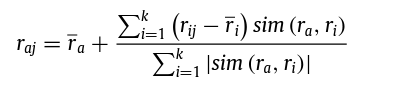

where we gather data from the $k$ nearest neighbors of the query user according to the normalized Cosine Jaccard measure:

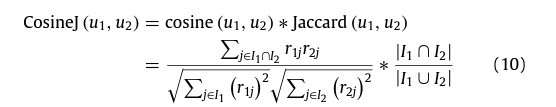

We will take $k = 20$, and we begin by identifying the 20 nearest neighbors of each user.

In [ ]:
def cosj_sim(rating_matrix, movies_viewed, norms, movie_id_to_idx, userid_1, userid_2):
  user_1 = rating_matrix[userid_1 - 1]
  user_2 = rating_matrix[userid_2 - 1]
  user_1_viewed = movies_viewed[userid_1]
  user_2_viewed = movies_viewed[userid_2]
  set_user_1_viewed = set(user_1_viewed)
  set_user_2_viewed = set(user_2_viewed)

  dot_product = 0
  norm_1 = norms[userid_1 - 1]
  norm_2 = norms[userid_2 - 1]
  count_one_rated = len(set_user_1_viewed | set_user_2_viewed)
  both_rated = set_user_1_viewed & set_user_2_viewed
  count_both_rated = len(both_rated)

  for movie_id in list(both_rated):
    movie_idx = movie_id_to_idx[movie_id]
    dot_product += user_1[movie_idx] * user_2[movie_idx]

  if (norm_1 == 0 or norm_2 == 0) or count_one_rated == 0:
    return 0

  return (dot_product * count_both_rated) / (norm_1 * norm_2 * count_one_rated)

def cos_sim(rating_matrix, movies_viewed, norms, movie_id_to_idx, userid_1, userid_2):
  user_1 = rating_matrix[userid_1 - 1]
  user_2 = rating_matrix[userid_2 - 1]
  user_1_viewed = movies_viewed[userid_1]
  user_2_viewed = movies_viewed[userid_2]
  set_user_1_viewed = set(user_1_viewed)
  set_user_2_viewed = set(user_2_viewed)

  dot_product = 0
  norm_1 = norms[userid_1 - 1]
  norm_2 = norms[userid_2 - 1]
  both_rated = set_user_1_viewed & set_user_2_viewed

  for movie_id in list(both_rated):
    movie_idx = movie_id_to_idx[movie_id]
    dot_product += user_1[movie_idx] * user_2[movie_idx]

  if norm_1 == 0 or norm_2 == 0:
    return 0

  return dot_product / (norm_1 * norm_2)

In [ ]:
def generate_similarity_vector(user_id, rating_matrix, movies_viewed, norms, movie_id_to_idx):
  vector = np.zeros(NUM_USERS)

  for i in range(NUM_USERS):
    vector[i] = cos_sim(rating_matrix, movies_viewed, norms, movie_id_to_idx, user_id, i + 1)

  vector[user_id - 1] = 0
  return vector

def generate_similarity_matrix(rating_matrix, movies_reviewed, users_norm, movie_id_to_idx):
  similarity_matrix = np.zeros((NUM_USERS, NUM_USERS))

  for i in range(NUM_USERS):
    for j in range(i + 1, NUM_USERS):
      sim = cos_sim(rating_matrix, movies_reviewed, users_norm, movie_id_to_idx, i + 1, j + 1)
      similarity_matrix[i][j] = sim
      similarity_matrix[j][i] = sim

  return similarity_matrix

In [ ]:
def top_k_neighbors_idx(user_id, k, similarity_vector, movie_id, movies_viewed):
  sorted_indices = similarity_vector.argsort()
  arr = []
  i = 1
  while len(arr) < k and i <= NUM_USERS:
    idx = sorted_indices[-i]
    if movie_id in movies_viewed[idx + 1]:
      arr.append(idx)
    i += 1
  return arr

We are now ready to implement the given formula to predict a user's rating of a given movie.

In [ ]:
def predict_rating(user_id, movie_id, rating_matrix, similarity_vector, movie_id_to_idx, movies_viewed, avg_ratings, k):
  similar_users = top_k_neighbors_idx(user_id, k, similarity_vector, movie_id, movies_viewed)
  movie_idx = movie_id_to_idx[movie_id]
  numerator = 0
  denominator = 0

  for neighbor_idx in similar_users:
    rating_given = rating_matrix[neighbor_idx][movie_idx]
    similarity = similarity_vector[neighbor_idx]
    denominator += abs(similarity)
    if rating_given != 0:
      numerator += (rating_given - avg_ratings[neighbor_idx]) * similarity

  if denominator == 0:
    return 0

  return avg_ratings[user_id - 1] + numerator / denominator

Let's try it out! We can predict user 1's rating of movies with ID 296, 306, 307, which are 1, 0.666..., and 1 in reality.

In [ ]:
id_to_idx = ids_to_indices(movies_np)
user_ratings, movies_viewed, norms, avg_ratings = initialize(users_np, id_to_idx)
similarities = generate_similarity_vector(1, user_ratings, movies_viewed, norms, id_to_idx)

In [ ]:
print(predict_rating(1, 296, user_ratings, similarities, id_to_idx, movies_viewed, avg_ratings, 50))
print(predict_rating(1, 306, user_ratings, similarities, id_to_idx, movies_viewed, avg_ratings, 50))
print(predict_rating(1, 899, user_ratings, similarities, id_to_idx, movies_viewed, avg_ratings, 50))

4.27156793007519
4.45422885249217
4.208742812804082


In [ ]:
arr = generate_similarity_matrix(user_ratings, movies_viewed, norms, id_to_idx)

In [ ]:
rating_predictions = np.zeros((NUM_USERS, NUM_MOVIES))
for i in range(NUM_USERS):
  vector = arr[i]
  for movie_id in movies_viewed[i + 1]:
    rating_predictions[i][id_to_idx[movie_id]] = predict_rating(i + 1, movie_id, user_ratings, vector, id_to_idx, movies_viewed, avg_ratings, 5)

In [ ]:
# compute MAE
error = 0
count = 0
for i in range(NUM_USERS):
  for j in range(NUM_MOVIES):
    if user_ratings[i][j] != 0:
      count += 1
      error += abs(user_ratings[i][j] - rating_predictions[i][j])

print(error / count)

0.7377525155795635


In [ ]:
# save ratings
np.savetxt('rating_predictions.csv', rating_predictions, delimiter=',')